# Bootstrap quantile uncertainty

Here's a brief note on estimating the uncertainty of quantiles derived from samples from a distribution. For example you might want to estimate a 90% credible interval and median value from posterior probability distribution samples from an MCMC. As you only have a finite number of samples there will be uncertainties on the quantiles used. This uncertainty can be estimate via bootstrapping methods. The one I will demonstrate here resamples the chains with replacement multiple times and recalculating the quatiles each time (see, e.g., Section 4.2 of [Higson *et al*, *Bayesian Analysis*, **13**, 2018](https://projecteuclid.org/euclid.ba/1508897094)). The standard deviation of these values over the range of resampled chains can give an estimate of the quantile uncertainty.

I will test the bootstrapping for two examples:

1. the probability distribution being sampled from is a unimodal Gaussian with known mean and standard deviation, so we can actually draw new samples from it to test the "real" uncertainty on the quantiles;
2. the probability distribution being sampled from is a disjoint bi-modal Gaussuan (with known means and standard deviations).

The latter case tests how the bootstrapping error estimate performs for the median value (50% quantile), which can swap back and forth between the modes in different realisations and lead to larger uncertainties.

I will estimate the 5%, 50% (median) and 95% quantiles using the Numpy [`quantile`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.quantile.html) function.

In [1]:
%matplotlib inline

from matplotlib import pyplot as pl
import numpy as np

[-1.64219457e+00  9.14552286e-04  1.65513612e+00] [0.04604522 0.02911804 0.04520648]
[-1.60838284 -0.03563079  1.59193134] [0.05015117 0.02489716 0.06318228]


Text(0.5, 1.0, 'Quantiles redrawn using bootstrapping')

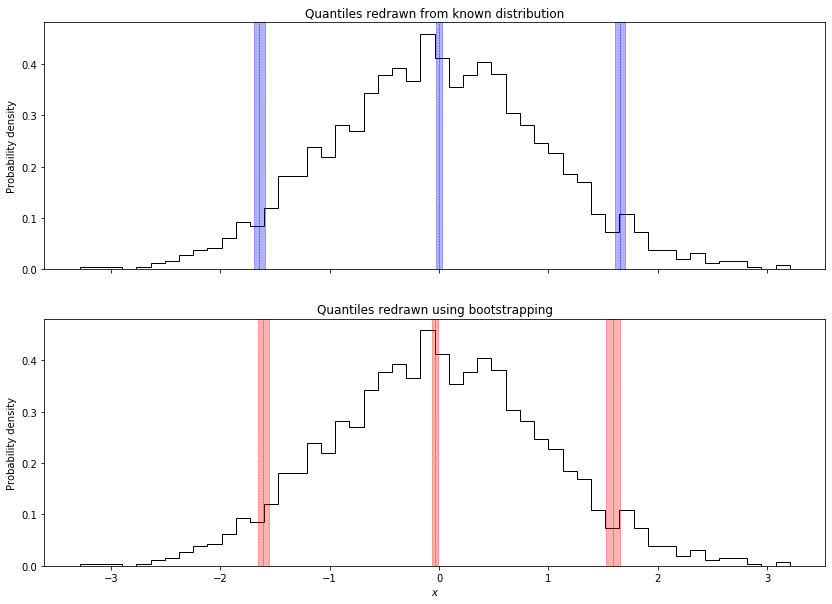

In [18]:
# generate 2000 samples from a unimodal Gaussian
mu = 0.
sig = 1.

nsamps = 2000

quants = [0.05, 0.5, 0.95]  # quantiles

# initial draws from distribution (i.e., your MCMC chain)
inidist = np.random.normal(mu, sig, nsamps)
iniquant = np.quantile(inidist, quants)

Ntest = 50  # number of realisations for the bootstrapping
qs = np.zeros((Ntest, len(quants)))
qsbootstrap = np.zeros((Ntest, len(quants)))

for i in range(Ntest):
    # quantiles from redrawing samples from the known distribution
    qs[i, :] = np.quantile(np.random.normal(mu, sig, nsamps), quants)

    idx = np.random.randint(0, nsamps, nsamps)  # resample with replacement (i.e. allowing repeated samples)
    
    # quantiles from bootstrapping the original samples
    qsbootstrap[i, :] = np.quantile(inidist[idx], quants)

# print standard deviations of the credible intervals
qsmeans = np.mean(qs, axis=0)
qsstds = np.std(qs, axis=0, ddof=1)

qsbsmeans = np.mean(qsbootstrap, axis=0)
qsbsstds = np.std(qsbootstrap, axis=0, ddof=1)

print(qsmeans, qsstds)
print(qsbsmeans, qsbsstds)

# plot distribution, quatiles and uncertainties
fig, ax = pl.subplots(2, 1, figsize=(14, 10), sharex=True)

ax[0].hist(inidist, bins=50, density=True, histtype="step", color="k");
ax[1].hist(inidist, bins=50, density=True, histtype="step", color="k");
ax[1].set_xlabel("$x$");
ax[0].set_ylabel("Probability density");
ax[1].set_ylabel("Probability density");

for qmu, qsig in zip(qsmeans, qsstds):
    ax[0].axvline(qmu, color="b", lw=0.5, ls="--")
    ax[0].axvspan(qmu - qsig, qmu + qsig, alpha=0.3, color="b")
    
for qmu, qsig in zip(qsbsmeans, qsbsstds):
    ax[1].axvline(qmu, color="r", lw=0.5, ls="--")
    ax[1].axvspan(qmu - qsig, qmu + qsig, alpha=0.3, color="r")
    
ax[0].set_title("Quantiles redrawn from known distribution")
ax[1].set_title("Quantiles redrawn using bootstrapping")

[-1.27203778  3.77817941  8.26787606] [0.05064771 1.2604703  0.05049885]
[-1.23110791  4.16794142  8.27507925] [0.06328901 1.11482431 0.06529915]


Text(0.5, 1.0, 'Quantiles redrawn using bootstrapping')

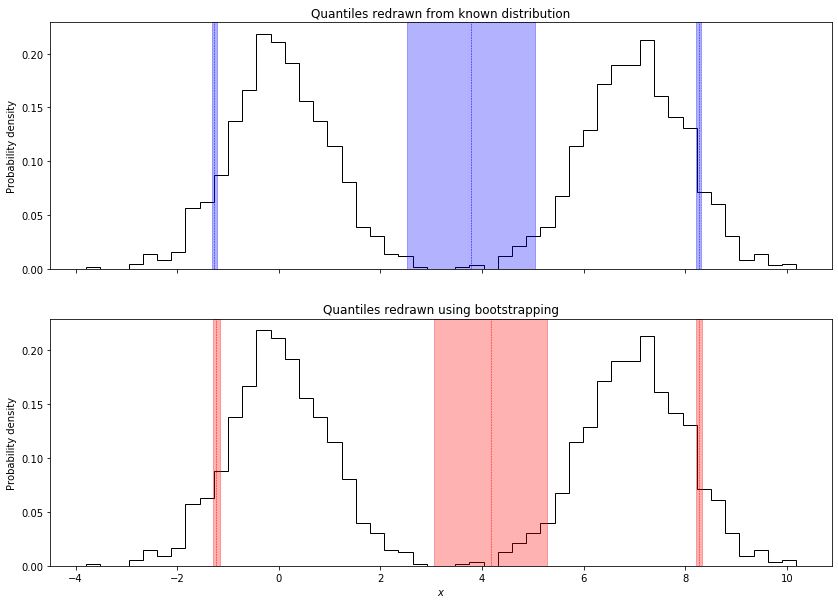

In [21]:
# generate 2000 samples from a bimodal Gaussian
mus = [0., 7]
sigs = [1., 1.]
weights = [0.5, 0.5]

nsamps = 2000

# initial draws from distribution (i.e., your MCMC chain)
inidist = np.random.normal(mus[0], sigs[0], nsamps)
for i in range(nsamps):
    if np.random.rand() > weights[0]:
        inidist[i] = np.random.normal(mus[1], sigs[1], 1)[0]
iniquant = np.quantile(inidist, quants)

qs = np.zeros((Ntest, len(quants)))
qsbootstrap = np.zeros((Ntest, len(quants)))

for i in range(Ntest):
    # quantiles from redrawing samples from the known distribution
    newdist = np.random.normal(mus[0], sigs[0], nsamps)
    for j in range(nsamps):
        if np.random.rand() > weights[0]:
            newdist[j] = np.random.normal(mus[1], sigs[1], 1)[0]
    qs[i, :] = np.quantile(newdist, quants)

    idx = np.random.randint(0, nsamps, nsamps)  # resample with replacement (i.e. allowing repeated samples)
    
    # quantiles from bootstrapping the original samples
    qsbootstrap[i, :] = np.quantile(inidist[idx], quants)

# print standard deviations of the credible intervals
qsmeans = np.mean(qs, axis=0)
qsstds = np.std(qs, axis=0, ddof=1)

qsbsmeans = np.mean(qsbootstrap, axis=0)
qsbsstds = np.std(qsbootstrap, axis=0, ddof=1)

print(qsmeans, qsstds)
print(qsbsmeans, qsbsstds)

# plot distribution, quatiles and uncertainties
fig, ax = pl.subplots(2, 1, figsize=(14, 10), sharex=True)

ax[0].hist(inidist, bins=50, density=True, histtype="step", color="k");
ax[1].hist(inidist, bins=50, density=True, histtype="step", color="k");
ax[1].set_xlabel("$x$");
ax[0].set_ylabel("Probability density");
ax[1].set_ylabel("Probability density");

for qmu, qsig in zip(qsmeans, qsstds):
    ax[0].axvline(qmu, color="b", lw=0.5, ls="--")
    ax[0].axvspan(qmu - qsig, qmu + qsig, alpha=0.3, color="b")
    
for qmu, qsig in zip(qsbsmeans, qsbsstds):
    ax[1].axvline(qmu, color="r", lw=0.5, ls="--")
    ax[1].axvspan(qmu - qsig, qmu + qsig, alpha=0.3, color="r")
    
ax[0].set_title("Quantiles redrawn from known distribution")
ax[1].set_title("Quantiles redrawn using bootstrapping")